In [1]:
import seaborn as sns
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
df = pd.read_pickle('./data/result_df.pkl')

In [3]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Concatenate, Dense, Attention, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [16]:
import datetime
df['day_in_month'] = df['CALL_START_DATE'].dt.day

In [17]:
col = df.columns.to_list()
col.remove('outcome')

In [18]:
col = col + ['outcome']

In [19]:
df_train = df[col]

In [23]:
df_train

,Customer_ID,CALL_MON_YEAR,past_repay_prob,PREVIOUS_MONTH_CALLS,CALL_DPD,DLNQNT_10_29_CNT,days_since_book,DLNQNT_60_89_CNT,BUYER_CUSTOM_CREDIT_SCORE,TOT_MO_PMT,...,DLNQNT_30_59_CNT,BUYER_CREDIT_SCORE,HIGHEST_LOAN_AMOUNT,TOTAL_BUREAU_PAYMENT_AMOUNT,FICO,TOTAL_INCOME_AMOUNT,DLNQNT_90_CNT,CALL_START_DATE,day_in_month,outcome
0,7350,2023-05,1.0,0.0,35,1,661,0,779,293.78,...,1,775,2000,17,775,5000,0,2023-05-11 15:03:46,11,0
1,8328,2023-01,1.0,0.0,69,16,1043,7,599,599.49,...,13,613,16887,0,613,8140,0,2023-01-24 15:34:29,24,0
2,8328,2023-01,1.0,0.0,69,16,1046,7,599,599.49,...,13,613,16887,0,613,8140,0,2023-01-27 14:49:59,27,0
3,8328,2023-01,1.0,0.0,69,16,1046,7,599,599.49,...,13,613,16887,0,613,8140,0,2023-01-28 10:39:56,28,0
4,8328,2023-01,1.0,0.0,69,16,1046,7,599,599.49,...,13,613,16887,0,613,8140,0,2023-01-28 10:41:35,28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118699,99992127,2023-03,1.0,0.0,10,0,163,0,708,555.58,...,0,745,7200,70,745,5000,0,2023-03-01 11:58:11,1,1
118700,99992127,2023-04,1.0,2.0,10,0,220,0,708,555.58,...,0,745,7200,70,745,5000,0,2023-04-26 12:00:47,26,1
118701,99995487,2022-05,1.0,0.0,8,5,497,0,750,484.84,...,0,739,385000,817,739,7500,0,2022-05-16 12:03:06,16,0
118702,99995487,2022-05,1.0,0.0,8,5,497,0,750,484.84,...,0,739,385000,817,739,7500,0,2022-05-16 12:03:53,16,0


In [20]:
# Group by Customer_ID and CALL_MON_YEAR
grouped = df_train.groupby(['Customer_ID', 'CALL_MON_YEAR'])

# Initialize an empty list to store sequences
sequences = []

# Iterate through groups and create sequences
for (customer_id, call_mon_year), group_df in grouped:
    sequence = group_df.drop(['Customer_ID', 'CALL_MON_YEAR', 'CALL_START_DATE'], axis=1).values
    sequences.append(sequence)

In [21]:
# Separate the sequences into features and targets
sequences_features = [sequence[:, :-1] for sequence in sequences]
sequences_targets = [sequence[:, -1] for sequence in sequences]

# Standardize the features
all_data = np.concatenate(sequences_features)
scaler = StandardScaler()
scaler.fit(all_data)
scaled_sequences_features = [scaler.transform(sequence) for sequence in sequences_features]


In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Dropout, Bidirectional, LSTM
from keras.models import Model
import numpy as np
from keras.layers import Flatten

In [22]:
from keras.layers import Input, Bidirectional, LSTM, Flatten, Dropout, Dense
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
def create_sequences(data):
    X, y = [], []
    for sequence in data:
        X.append(sequence[:-1])
        y.append(sequence[-1][-1]) # Assuming the outcome is the last element
    return X, np.array(y)

sequences = [np.concatenate([features, targets.reshape(-1, 1)], axis=1) for features, targets in zip(scaled_sequences_features, sequences_targets)]
X_sequences, y_sequences = create_sequences(sequences)

# Pad the sequences
max_sequence_length = max([len(sequence) for sequence in X_sequences])
X_sequences_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post', dtype='float32')

X_train, X_test, y_train, y_test = train_test_split(X_sequences_padded, y_sequences, test_size=0.2, random_state=42)

In [153]:
# Define the model
input_layer = Input(shape=(max_sequence_length, X_train.shape[2]))
bi_lstm = Bidirectional(LSTM(50, return_sequences=True, kernel_regularizer=l2(0.001)))(input_layer)
flatten = Flatten()(bi_lstm)
dropout = Dropout(0.5)(flatten)
hidden_dense = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(dropout) # Additional Dense layer
output_layer = Dense(1, activation='sigmoid')(hidden_dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
model.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint])

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 115, 22)]         0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 115, 100)          29200     
 onal)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 11500)             0         
                                                                 
 dropout_7 (Dropout)         (None, 11500)             0         
                                                                 
 dense_8 (Dense)             (None, 32)                368032    
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                           

c:\Users\rheah\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


207/207 [==============================] - 82s 396ms/step - loss: 0.4055 - accuracy: 0.8387 - val_loss: 0.4019 - val_accuracy: 0.8361
Epoch 3/50
207/207 [==============================] - 86s 414ms/step - loss: 0.3907 - accuracy: 0.8388 - val_loss: 0.3861 - val_accuracy: 0.8389
Epoch 4/50
207/207 [==============================] - 90s 434ms/step - loss: 0.3943 - accuracy: 0.8377 - val_loss: 0.3983 - val_accuracy: 0.8357
Epoch 5/50
207/207 [==============================] - 97s 468ms/step - loss: 0.3835 - accuracy: 0.8404 - val_loss: 0.3844 - val_accuracy: 0.8382
Epoch 6/50
207/207 [==============================] - 110s 531ms/step - loss: 0.3769 - accuracy: 0.8388 - val_loss: 0.3860 - val_accuracy: 0.8342
Epoch 7/50
207/207 [==============================] - 106s 513ms/step - loss: 0.3732 - accuracy: 0.8399 - val_loss: 0.3738 - val_accuracy: 0.8372
Epoch 8/50
207/207 [==============================] - 109s 526ms/step - loss: 0.3724 - accuracy: 0.8397 - val_loss: 0.3808 - val_accuracy: 

In [44]:
test = df_train[df_train['Customer_ID'] == 8328]
test[['Customer_ID', 'CALL_START_DATE', 'DLNQNT_60_89_CNT']]

,Customer_ID,CALL_START_DATE,DLNQNT_60_89_CNT
1,8328,2023-01-24 15:34:29,7
2,8328,2023-01-27 14:49:59,7
3,8328,2023-01-28 10:39:56,7
4,8328,2023-01-28 10:41:35,7
5,8328,2023-01-31 14:55:47,7
...,...,...,...
63,8328,2023-04-20 11:37:08,7
64,8328,2023-04-20 11:37:56,7
65,8328,2023-04-20 11:40:22,7
66,8328,2023-04-20 11:41:46,7


In [37]:
import pickle

file_path = './data/model.pkl'

# export dataframes
with open(file_path, 'wb') as f:
    pickle.dump(model, f)

In [154]:
df_reduced.columns

Index(['Customer_ID', 'CALL_MON_YEAR', 'past_repay_prob',
       'PREVIOUS_MONTH_CALLS', 'CALL_DPD', 'DLNQNT_10_29_CNT',
       'days_since_book', 'DLNQNT_60_89_CNT', 'BUYER_CUSTOM_CREDIT_SCORE',
       'TOT_MO_PMT', 'ORIGINAL_COMBINED_DEBT_TO_INCOME',
       'ORIGINAL_COMBINED_PAYMENT_TO_INC', 'APPLICANT_AGE',
       'UNPAID_CASH_BALANCE_AMOUNT', 'TOTAL_MONTHLY_PAYMENT_AMOUNT',
       'DLNQNT_30_59_CNT', 'BUYER_CREDIT_SCORE', 'HIGHEST_LOAN_AMOUNT',
       'TOTAL_BUREAU_PAYMENT_AMOUNT', 'FICO', 'TOTAL_INCOME_AMOUNT',
       'DLNQNT_90_CNT', 'day_in_month', 'outcome', 'CALLS_CURRENT_MONTH',
       'repay_prob', 'risk_group'],
      dtype='object')

In [157]:
df_test = df_reduced.drop(['Customer_ID', 'CALL_MON_YEAR', 'day_in_month',
                            'CALLS_CURRENT_MONTH','repay_prob', 'risk_group'], axis=1)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118704 entries, 0 to 118703
Data columns (total 25 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Customer_ID                       118704 non-null  int64         
 1   CALL_MON_YEAR                     118704 non-null  object        
 2   past_repay_prob                   118704 non-null  float64       
 3   PREVIOUS_MONTH_CALLS              118704 non-null  float64       
 4   CALL_DPD                          118704 non-null  int64         
 5   DLNQNT_10_29_CNT                  118704 non-null  int64         
 6   days_since_book                   118704 non-null  int64         
 7   DLNQNT_60_89_CNT                  118704 non-null  int64         
 8   BUYER_CUSTOM_CREDIT_SCORE         118704 non-null  int64         
 9   TOT_MO_PMT                        118704 non-null  float64       
 10  ORIGINAL_COMBINED_DEBT_TO_INCOME

In [159]:
df_test.columns

Index(['past_repay_prob', 'PREVIOUS_MONTH_CALLS', 'CALL_DPD',
       'DLNQNT_10_29_CNT', 'days_since_book', 'DLNQNT_60_89_CNT',
       'BUYER_CUSTOM_CREDIT_SCORE', 'TOT_MO_PMT',
       'ORIGINAL_COMBINED_DEBT_TO_INCOME', 'ORIGINAL_COMBINED_PAYMENT_TO_INC',
       'APPLICANT_AGE', 'UNPAID_CASH_BALANCE_AMOUNT',
       'TOTAL_MONTHLY_PAYMENT_AMOUNT', 'DLNQNT_30_59_CNT',
       'BUYER_CREDIT_SCORE', 'HIGHEST_LOAN_AMOUNT',
       'TOTAL_BUREAU_PAYMENT_AMOUNT', 'FICO', 'TOTAL_INCOME_AMOUNT',
       'DLNQNT_90_CNT', 'outcome'],
      dtype='object')

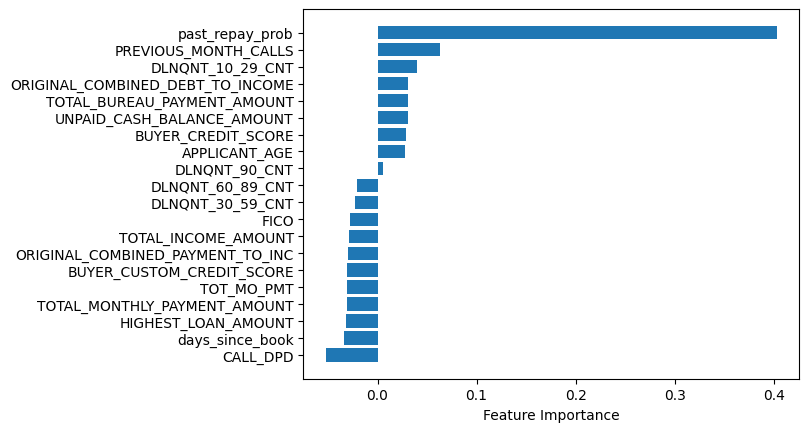

In [161]:
from sklearn.preprocessing import StandardScaler

X = df_test.drop('outcome', axis=1)
y = df_test['outcome']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_scaled, y)

coefficients = model.coef_[0]

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X, y)
feature_importances = rf_model.feature_importances_

combined_importance = feature_importances * np.sign(coefficients)
sorted_idx = combined_importance.argsort()
plt.barh(X.columns[sorted_idx], combined_importance[sorted_idx])
plt.xlabel('Feature Importance')
plt.show()


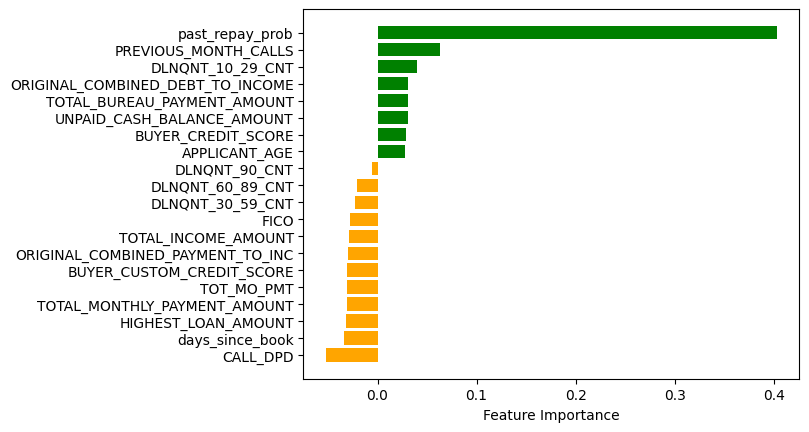

In [174]:
colors = ['g' if value > 0 else 'orange' for value in tmp]

# Plotting the feature importance
plt.barh(X.columns[sorted_idx], tmp, color=colors)
plt.xlabel('Feature Importance')
plt.show()

In [201]:
X.columns[sorted_idx][7]

'TOTAL_INCOME_AMOUNT'

In [ ]:
cols = ['CALL_DPD', 'days_since_book', 'HIGHEST_LOAN_AMOUNT',
       'TOTAL_MONTHLY_PAYMENT_AMOUNT', 'TOT_MO_PMT',
       'BUYER_CUSTOM_CREDIT_SCORE', 'ORIGINAL_COMBINED_PAYMENT_TO_INC',
       'TOTAL_INCOME_AMOUNT', 'FICO', 'DLNQNT_30_59_CNT', 'DLNQNT_60_89_CNT',
       'DLNQNT_90_CNT', 'APPLICANT_AGE', 'BUYER_CREDIT_SCORE',
       'UNPAID_CASH_BALANCE_AMOUNT', 'TOTAL_BUREAU_PAYMENT_AMOUNT',
       'ORIGINAL_COMBINED_DEBT_TO_INCOME', 'DLNQNT_10_29_CNT',
       'PREVIOUS_MONTH_CALLS', 'past_repay_prob']

In [171]:
tmp = combined_importance[sorted_idx].copy()
tmp[11] = -0.005657672469888768

In [172]:
tmp

array([-0.05196766, -0.03379686, -0.03177277, -0.03120114, -0.03103315,
       -0.03030427, -0.02977233, -0.02848405, -0.02804738, -0.02243466,
       -0.0202225 , -0.00565767,  0.02822092,  0.02837196,  0.03055685,
        0.03099944,  0.03119113,  0.03971053,  0.06308606,  0.40316866])

In [ ]:
feature_importances = model.feature_importances_


## reduce dataset

In [51]:
repayment_probabilities = model.predict(X_sequences_padded).flatten()

1034/1034 [==============================] - 52s 51ms/step


In [52]:
df_reduced = df_train.groupby(['Customer_ID', 'CALL_MON_YEAR']).last().reset_index()
df_reduced = df_reduced.drop(['CALL_START_DATE'], axis=1)
df_reduced['CALLS_CURRENT_MONTH'] = df_train.groupby(['Customer_ID', 'CALL_MON_YEAR'])['Customer_ID'].transform(lambda x: x.count())

In [56]:
def calculate_days_saved(df, threshold):
    # Filter rows where the predicted repayment is 0 (i.e., below the threshold)
    no_repayment_rows = df[df['repay_prob'] < threshold]
    
    # Sum the "CALLS_CURRENT_MONTH" for these rows
    total_calls_saved = no_repayment_rows['CALLS_CURRENT_MONTH'].sum()
    
    # Get the mean by dividing by the number of rows with predicted no repayment
    mean_calls_saved = no_repayment_rows['CALLS_CURRENT_MONTH'].mean()

    mean_calls_saved = mean_calls_saved if not np.isnan(mean_calls_saved) else 0
    
    return total_calls_saved, mean_calls_saved

In [63]:
min(repayment_probabilities)

1.5807453e-24

In [71]:
from sklearn.metrics import f1_score
# Add the repayment probabilities to df_reduced
df_reduced['repay_prob'] = repayment_probabilities

# Define thresholds
thresholds = [0.75, 0.50, 0.20, 0.15, 0.1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-20]

# Iterate through thresholds and calculate accuracy and days saved
for threshold in thresholds:
    # Calculate predicted repayment status based on threshold
    predicted_outcome = (df_reduced['repay_prob'] >= threshold).astype(int)

    # Calculate accuracy
    f1 = f1_score(df_reduced['outcome'], predicted_outcome)
    print(f"For threshold {threshold * 100}%, the F1 score is {f1 * 100:.2f}%")


    # Calculate the number of days saved based on your specific business logic
    # Here's a placeholder, replace with your actual logic
    days_saved = calculate_days_saved(df_reduced, threshold)
    print(f"For threshold {threshold * 100}%, the number of days saved is {days_saved}")


For threshold 75.0%, the F1 score is 60.76%
For threshold 75.0%, the number of days saved is (346129, 15.54937106918239)
For threshold 50.0%, the F1 score is 90.67%
For threshold 50.0%, the number of days saved is (93781, 15.26880494952784)
For threshold 20.0%, the F1 score is 90.71%
For threshold 20.0%, the number of days saved is (72494, 15.26832350463353)
For threshold 15.0%, the F1 score is 90.61%
For threshold 15.0%, the number of days saved is (70181, 15.243483927019982)
For threshold 10.0%, the F1 score is 90.47%
For threshold 10.0%, the number of days saved is (68531, 15.252837747607389)
For threshold 10.0%, the F1 score is 90.47%
For threshold 10.0%, the number of days saved is (68531, 15.252837747607389)
For threshold 1.0%, the F1 score is 90.02%
For threshold 1.0%, the number of days saved is (63717, 15.257902298850574)
For threshold 0.1%, the F1 score is 89.73%
For threshold 0.1%, the number of days saved is (60938, 15.261207112446781)
For threshold 0.01%, the F1 score is 8

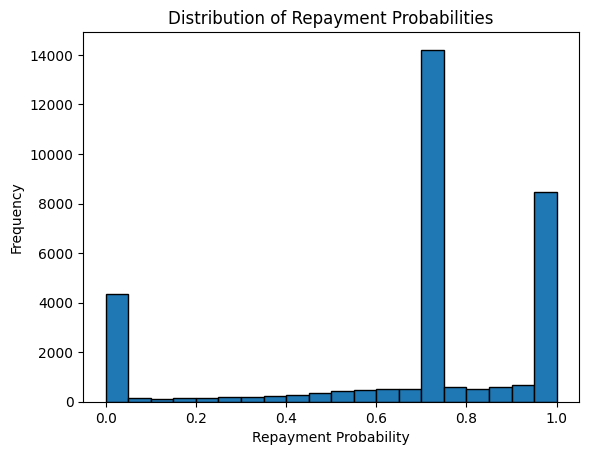

In [59]:
import matplotlib.pyplot as plt

plt.hist(df_reduced['repay_prob'], bins=20, edgecolor='black')
plt.title('Distribution of Repayment Probabilities')
plt.xlabel('Repayment Probability')
plt.ylabel('Frequency')
plt.show()


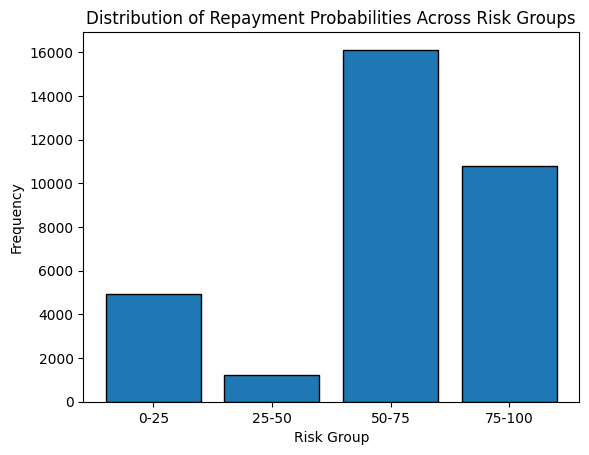

In [73]:
import pandas as pd

# Define the buckets
buckets = ['0-25', '25-50', '50-75', '75-100']
counts = [
    df_reduced[(df_reduced['repay_prob'] >= 0) & (df_reduced['repay_prob'] < 0.25)].shape[0],
    df_reduced[(df_reduced['repay_prob'] >= 0.25) & (df_reduced['repay_prob'] < 0.5)].shape[0],
    df_reduced[(df_reduced['repay_prob'] >= 0.5) & (df_reduced['repay_prob'] < 0.75)].shape[0],
    df_reduced[(df_reduced['repay_prob'] >= 0.75) & (df_reduced['repay_prob'] <= 1)].shape[0],
]

plt.bar(buckets, counts, edgecolor='black')
plt.title('Distribution of Repayment Probabilities Across Risk Groups')
plt.xlabel('Risk Group')
plt.ylabel('Frequency')
plt.show()


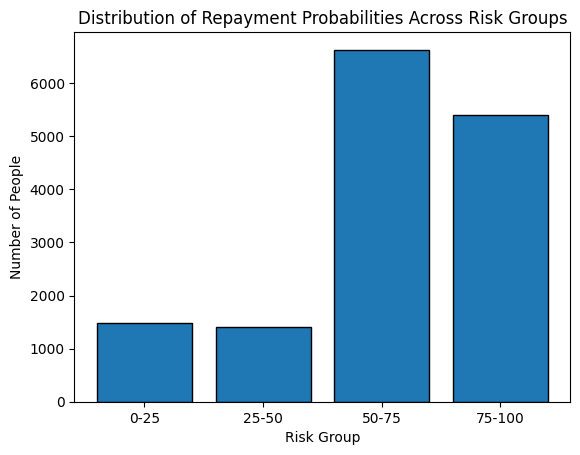

In [186]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Customer_ID and calculate the mean of repay_prob
customer_avg_repay_prob = df_reduced.groupby('Customer_ID')['repay_prob'].mean()

# Define the buckets
buckets = ['0-25', '25-50', '50-75', '75-100']
counts = [
    customer_avg_repay_prob[(customer_avg_repay_prob >= 0) & (customer_avg_repay_prob < 0.25)].shape[0],
    customer_avg_repay_prob[(customer_avg_repay_prob >= 0.25) & (customer_avg_repay_prob < 0.5)].shape[0],
    customer_avg_repay_prob[(customer_avg_repay_prob >= 0.5) & (customer_avg_repay_prob < 0.75)].shape[0],
    customer_avg_repay_prob[(customer_avg_repay_prob >= 0.75) & (customer_avg_repay_prob <= 1)].shape[0],
]

plt.bar(buckets, counts, edgecolor='black')
plt.title('Distribution of Repayment Probabilities Across Risk Groups')
plt.xlabel('Risk Group')
plt.ylabel('Number of People')
plt.show()


Transition Matrix:
[[0.63764962 0.36235038]
 [0.09108998 0.90891002]]


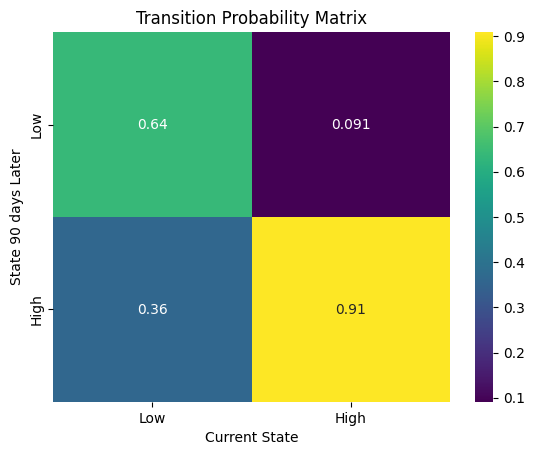

In [88]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert CALL_MON_YEAR to a datetime object
df_reduced['CALL_MON_YEAR'] = pd.to_datetime(df_reduced['CALL_MON_YEAR'])

# Define the transition matrix
transition_matrix = np.zeros((2, 2))

# Group by customer and iterate through each group
for customer_id, customer_data in df_reduced.groupby('Customer_ID'):
    customer_data = customer_data.sort_values('CALL_MON_YEAR')
    
    # Iterate through the customer's data, looking for a 3-month difference
    for i in range(len(customer_data)):
        current_prob = customer_data.iloc[i]['repay_prob']
        current_state = 0 if current_prob < 0.5 else 1

        # Find a record that is 3 months later
        future_data = customer_data[customer_data['CALL_MON_YEAR'] == customer_data.iloc[i]['CALL_MON_YEAR'] + pd.DateOffset(months=3)]
        if not future_data.empty:
            future_prob = future_data.iloc[0]['repay_prob']
            future_state = 0 if future_prob < 0.5 else 1
        
            # Increment the transition count
            transition_matrix[current_state, future_state] += 1

# Normalize the transition matrix, avoiding division by zero
row_sums = transition_matrix.sum(axis=1)
transition_matrix = np.divide(transition_matrix, row_sums[:, None], where=row_sums[:, None] != 0)

# Print the transition matrix
print("Transition Matrix:")
print(transition_matrix)

# Plot the transition matrix
sns.heatmap(transition_matrix.T, annot=True, cmap='viridis', # Transposing the matrix
            xticklabels=['Low', 'High'],
            yticklabels=['Low', 'High'])
plt.title('Transition Probability Matrix')
plt.xlabel('Current State')
plt.ylabel('State 90 days Later')
plt.show()


In [188]:
# Lists to store customer IDs
always_low_customers = []
always_high_customers = []
transition_high_to_low_customers = []
transition_low_to_high_customers = []

# Group by customer and iterate through each group
for customer_id, customer_data in df_reduced.groupby('Customer_ID'):
    customer_data = customer_data.sort_values('CALL_MON_YEAR')
    
    # Track the state history of the customer
    state_history = []
    
    # Define the current state based on the first row of the group
    current_prob = customer_data.iloc[0]['repay_prob']
    current_state = 0 if current_prob < 0.25 else 1
    current_date = customer_data.iloc[0]['CALL_MON_YEAR']

    # Iterate through the customer's data, starting from the second row
    for i in range(1, len(customer_data)):
        next_date = customer_data.iloc[i]['CALL_MON_YEAR']
        
        # Check if the next record is three months later
        if (next_date - current_date).days >= 90:
            future_prob = customer_data.iloc[i]['repay_prob']
            future_state = 0 if future_prob < 0.25 else 1
            
            # Check if the customer transitioned from high to low
            if current_state == 1 and future_state == 0:
                transition_high_to_low_customers.append(customer_id)
                break
            
            # Check if the customer is always in the low state
            if current_state == 0 and future_state == 0:
                always_low_customers.append(customer_id)
                break

            # Check if the customer transitioned from low to high
            if current_state == 0 and future_state == 1:
                transition_low_to_high_customers.append(customer_id)
                break
            
            # Check if the customer is always in the high state
            if current_state == 1 and future_state == 1:
                always_high_customers.append(customer_id)
                break

print("Customers always in the low group:", always_low_customers)
print("Customers always in the high group:", always_high_customers)
print("Customers transitioning from high to low:", transition_high_to_low_customers)
print("Customers transitioning from low to high:", transition_low_to_high_customers)


Customers always in the low group: [8328, 88656, 266775, 367386, 392746, 434547, 477948, 482488, 628367, 648998, 732948, 786122, 790697, 799194, 831717, 842332, 888242, 1059711, 1191123, 1194341, 1212182, 1314708, 1347121, 1408334, 1460831, 1611170, 1800412, 1831391, 1887281, 2234318, 2243139, 2249100, 2335456, 2363956, 2474407, 2487880, 2557955, 2616993, 2707573, 2731383, 2745823, 2811435, 2883501, 3008423, 3053752, 3172531, 3182419, 3250446, 3262273, 3585145, 3634158, 3646598, 3674645, 3689602, 3829889, 3862027, 3966257, 3996504, 4078518, 4280132, 4343858, 4365963, 4597724, 4680837, 4684727, 4829773, 4911592, 4977371, 5006193, 5294111, 5373452, 5426767, 5432273, 5462733, 5569076, 5690800, 5868312, 5931562, 5966382, 5968537, 6051616, 6113329, 6153170, 6162386, 6313506, 6373026, 6407040, 6413795, 6417298, 6423202, 6443414, 6471800, 6508440, 6676133, 6677784, 6800201, 6833399, 6911822, 6971274, 7020417, 7039854, 7049436, 7264642, 7321103, 7538442, 7561449, 7619130, 7721042, 7796438, 794

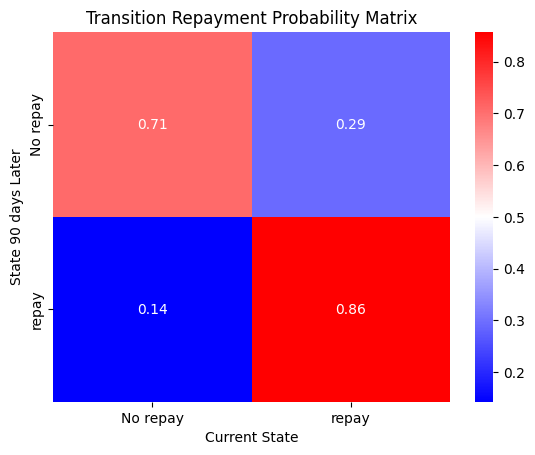

In [189]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Custom colormap: blue to white to red
cmap = LinearSegmentedColormap.from_list('custom', ['blue', 'white', 'red'], N=256)

# Create the transition matrix
total_low = len(always_low_customers) + len(transition_low_to_high_customers)
total_high = len(transition_high_to_low_customers) + len(always_high_customers)

transition_matrix = [
    [len(always_low_customers) / total_low, len(transition_low_to_high_customers) / total_low], # Transition from Low to Low and Low to High
    [len(transition_high_to_low_customers) / total_high, len(always_high_customers) / total_high]  # Transition from High to Low and High to High
]

# Plot the transition matrix
sns.heatmap(transition_matrix, annot=True, cmap=cmap,
            xticklabels=['No repay', 'repay'],
            yticklabels=['No repay', 'repay'])
plt.title('Transition Repayment Probability Matrix')
plt.xlabel('Current State')
plt.ylabel('State 90 days Later')
plt.show()


In [190]:
risky_group = always_low_customers 
len(risky_group)

228

In [193]:
df_risky = df[df['Customer_ID'].isin(risky_group)]

In [196]:
def calculate_saved_days(group):
    # Filter rows where any of the specified columns is not zero
    non_zero_dates = group[group[['DLNQNT_10_29_CNT', 'DLNQNT_60_89_CNT', 'DLNQNT_30_59_CNT', 'DLNQNT_90_CNT']].ne(0).any(axis=1)]
    
    # Get the first and largest dates from the filtered DataFrame
    first_date = non_zero_dates['CALL_START_DATE'].min()
    largest_date = group['CALL_START_DATE'].max()

    # Return the difference in days between the largest and first dates
    if first_date and largest_date:
        return (largest_date - first_date).days
    else:
        return 0

# Group by Customer_ID and apply the custom function
saved_days_per_customer = df_risky.groupby('Customer_ID').apply(calculate_saved_days)

# Sum the saved days across all customers
total_saved_days = saved_days_per_customer.sum()

print(f"Total saved days across customers: {total_saved_days}")


Total saved days across customers: 27175


In [138]:
len(df_risky_unique['DLNQNT_90_CNT'].value_counts())

12

In [139]:
df_risky_unique['DLNQNT_90_CNT'].value_counts()

0      670
1      110
2       38
3       21
5        7
4        7
245      1
145      1
15       1
80       1
9        1
7        1
Name: DLNQNT_90_CNT, dtype: int64

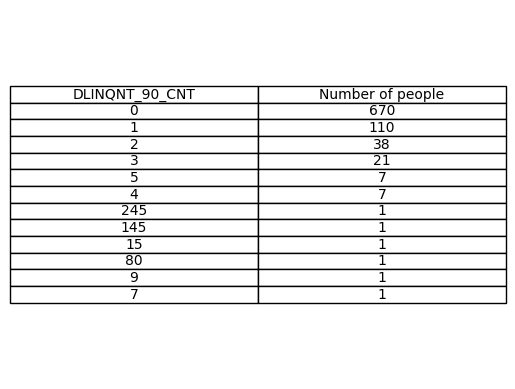

In [122]:
import matplotlib.pyplot as plt

data = {
    0: 670,
    1: 110,
    2: 38,
    3: 21,
    5: 7,
    4: 7,
    245: 1,
    145: 1,
    15: 1,
    80: 1,
    9: 1,
    7: 1
}

# Extract data for plotting
x = list(data.keys())
y = list(data.values())

# Plotting the table
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
ax.table(cellText=[[key, value] for key, value in data.items()],
         colLabels=['DLINQNT_90_CNT', 'Number of people'],
         cellLoc = 'center', loc='center')

plt.show()


In [147]:
# Group by customer ID
grouped = df_risky[df_risky['DLNQNT_90_CNT'] > 0].groupby('Customer_ID')

# Function to calculate the date difference for a group
def date_difference(group):
    return (group['CALL_MON_YEAR'].max() - group['CALL_MON_YEAR'].min()).days

# Apply the function to each group
date_diffs = grouped.apply(date_difference)

# Result will be a Series with Customer_ID as the index and the date difference as the values
print(date_diffs)



Customer_ID
40420        90
88656       120
229677      120
266775       90
392746       90
           ... 
98260227     92
98315467     90
98833577    120
99157807    120
99766667    120
Length: 171, dtype: int64


In [148]:
np.mean(date_diffs)

114.23976608187135

In [104]:
num = 0
for customer_id, customer_data in df_reduced.groupby('Customer_ID'):
    customer_data = customer_data.sort_values('CALL_MON_YEAR')
    
    # Track the state history of the customer
    current_date = customer_data.iloc[0]['CALL_MON_YEAR']
    
    # Iterate through the customer's data
    for i in range(1, len(customer_data)):
        next_date = customer_data.iloc[i]['CALL_MON_YEAR']
        
       
        # Check if the next record is three months later
        if (next_date - current_date).days >= 90:
            num += 1
            break

print("number of customers with more than 90 days on file:", num)

number of customers with more than 90 days on file: 4048


In [1]:
import pickle

file_path = './data/df_results.pkl'

# export dataframes
with open(file_path, 'wb') as f:
    pickle.dump(df_reduced, f)

NameError: name 'df_reduced' is not defined

In [3]:
import pandas as pd

In [4]:
df_reduced = pd.read_pickle('data/df_reduced.pkl')

In [5]:
df_reduced

,Customer_ID,CALL_MON_YEAR,TOTAL_MONTHLY_PAYMENT_AMOUNT,TOTAL_BUREAU_PAYMENT_AMOUNT,REVOLVING_TRADE_LINE_COUNT,REVOLVING_TRADE_LINE_PERCENT,FICO,REVOLVING_CREDIT_MONTHLY_PAYMENT,REVOLVING_CREDIT_HIGH_AMOUNT,REVOLVING_CREDIT_BALANCE_AMOUNT,...,REVOLVING_CREDIT_BALANCE_RATIO,FINANCE_COMPANY_TRADE_LINE_COUNT,DEPARTMENT_STORE_MONTHLY_PAYMENT,CURRENT_EMPLOYMENT_DURATION_NUMB,CURRENT_AUTOMOBILE_ACCOUNTS_COUN,CREDIT_REPORT_ACCOUNT_DISPUTE_CO,days_since_book,CALLS_CURRENT_MONTH,PREVIOUS_MONTH_CALLS,past_repay_prob
0,7350,2023-05,310,17,1,100,775,0,2000,17,...,100,0,0,3,0,0,661,1.0,0.0,1.0
1,8328,2023-01,1972,0,0,0,613,28,0,0,...,0,0,0,1,1,0,1050,8.0,0.0,1.0
2,8328,2023-02,1972,0,0,0,613,28,0,0,...,0,0,0,1,1,0,1078,8.0,8.0,0.0
3,8328,2023-03,1972,0,0,0,613,28,0,0,...,0,0,0,1,1,0,1106,8.0,8.0,0.0
4,8328,2023-04,1972,0,0,0,613,28,0,0,...,0,0,0,1,1,0,1128,8.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33069,99987007,2023-02,1243,746,3,6,756,38,1805,163,...,6,46,38,20,1,0,786,3.0,0.0,1.0
33070,99987007,2023-03,1243,746,3,6,756,38,1805,163,...,6,46,38,20,1,0,810,3.0,3.0,0.0
33071,99992127,2023-03,612,70,4,57,745,0,8700,1394,...,57,1,0,5,0,0,163,2.0,0.0,1.0
33072,99992127,2023-04,612,70,4,57,745,0,8700,1394,...,57,1,0,5,0,0,220,2.0,2.0,1.0


In [13]:
df_reduced = df_reduced.drop('APPLICANT_AGE', axis=1)

In [14]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33074 entries, 0 to 33073
Data columns (total 62 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Customer_ID                       33074 non-null  int64  
 1   CALL_MON_YEAR                     33074 non-null  object 
 2   TOTAL_MONTHLY_PAYMENT_AMOUNT      33074 non-null  int64  
 3   TOTAL_BUREAU_PAYMENT_AMOUNT       33074 non-null  int64  
 4   REVOLVING_TRADE_LINE_COUNT        33074 non-null  int64  
 5   REVOLVING_TRADE_LINE_PERCENT      33074 non-null  int64  
 6   FICO                              33074 non-null  int64  
 7   REVOLVING_CREDIT_MONTHLY_PAYMENT  33074 non-null  int64  
 8   REVOLVING_CREDIT_HIGH_AMOUNT      33074 non-null  int64  
 9   REVOLVING_CREDIT_BALANCE_AMOUNT   33074 non-null  int64  
 10  RESIDENCE_DURATION_NUMBER         33074 non-null  int64  
 11  TRADE_LINE_COUNT                  33074 non-null  int64  
 12  PERS

## marginal analysis for feature importance

In [25]:
import shap
import keras

# Load your trained LSTM model
model = keras.models.load_model('best_model.h5')

# Using a subset of your training data as background can help in approximating SHAP values.
# Do not use the entire training set as it will be computationally intensive.
background_data = X_train[:100] 

explainer = shap.GradientExplainer(model, background_data)
shap_values = explainer.shap_values(X_test)


StagingError: in user code:

    File "c:\Users\rheah\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_gradient.py", line 224, in grad_graph  *
        x_grad = tape.gradient(out, x)

    LookupError: gradient registry has no entry for: shap_StridedSlice


In [27]:
from keras.models import load_model
model = load_model("best_model.h5")

827/827 [==============================] - 11s 13ms/step


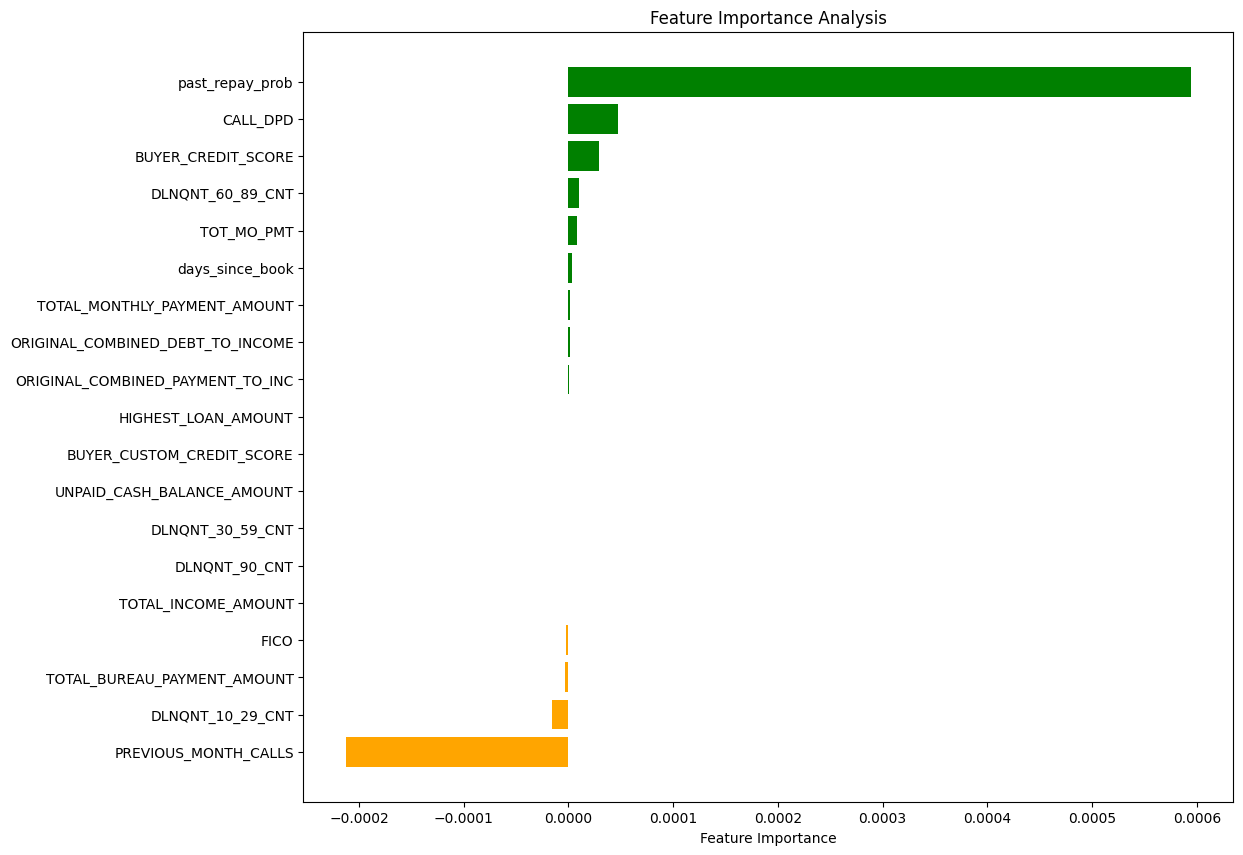

In [45]:
# Pre-calculate the original predictions
original_predictions = model.predict(X_train).flatten()

def compute_feature_importance(model, feature_idx, X_data, original_predictions):
    """
    This function perturbs the feature value by a small amount (e.g., 10%),
    then computes the difference in the model's predictions.
    """
    # Copy the original data to prevent in-place modifications
    X_data_perturbed = X_data.copy()
    
    # Perturb the feature value by a small amount (10%)
    perturbation = np.mean(X_data[:, :, feature_idx]) * 0.1
    X_data_perturbed[:, :, feature_idx] += perturbation
    
    # Predict using perturbed data
    perturbed_predictions = model.predict(X_data_perturbed).flatten()
    
    # Calculate the difference in predictions
    difference = np.mean(perturbed_predictions - original_predictions)

    return difference



# Features you want to analyze
features_to_analyze = [
    'past_repay_prob', 'PREVIOUS_MONTH_CALLS', 'CALL_DPD', 'DLNQNT_10_29_CNT', 
    'days_since_book', 'DLNQNT_60_89_CNT', 'BUYER_CUSTOM_CREDIT_SCORE', 'TOT_MO_PMT',
    'ORIGINAL_COMBINED_DEBT_TO_INCOME', 'ORIGINAL_COMBINED_PAYMENT_TO_INC', 
    'UNPAID_CASH_BALANCE_AMOUNT', 'TOTAL_MONTHLY_PAYMENT_AMOUNT', 
    'DLNQNT_30_59_CNT', 'BUYER_CREDIT_SCORE', 'HIGHEST_LOAN_AMOUNT', 
    'TOTAL_BUREAU_PAYMENT_AMOUNT', 'FICO', 'TOTAL_INCOME_AMOUNT', 'DLNQNT_90_CNT'
]

# Compute feature importance
importance_values = []
for idx, feature in enumerate(features_to_analyze):
    importance = compute_feature_importance(model, idx, X_train, original_predictions)
    importance_values.append(importance)

# Sort the importance values and indices
sorted_idx = np.argsort(importance_values)
tmp = np.array(importance_values)[sorted_idx]

# Determine colors based on positive/negative importance values
colors = ['g' if value > 0 else 'orange' for value in tmp]

# Plotting the feature importance
plt.figure(figsize=(12, 10))
plt.barh(np.array(features_to_analyze)[sorted_idx], tmp, color=colors)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Analysis')
plt.show()

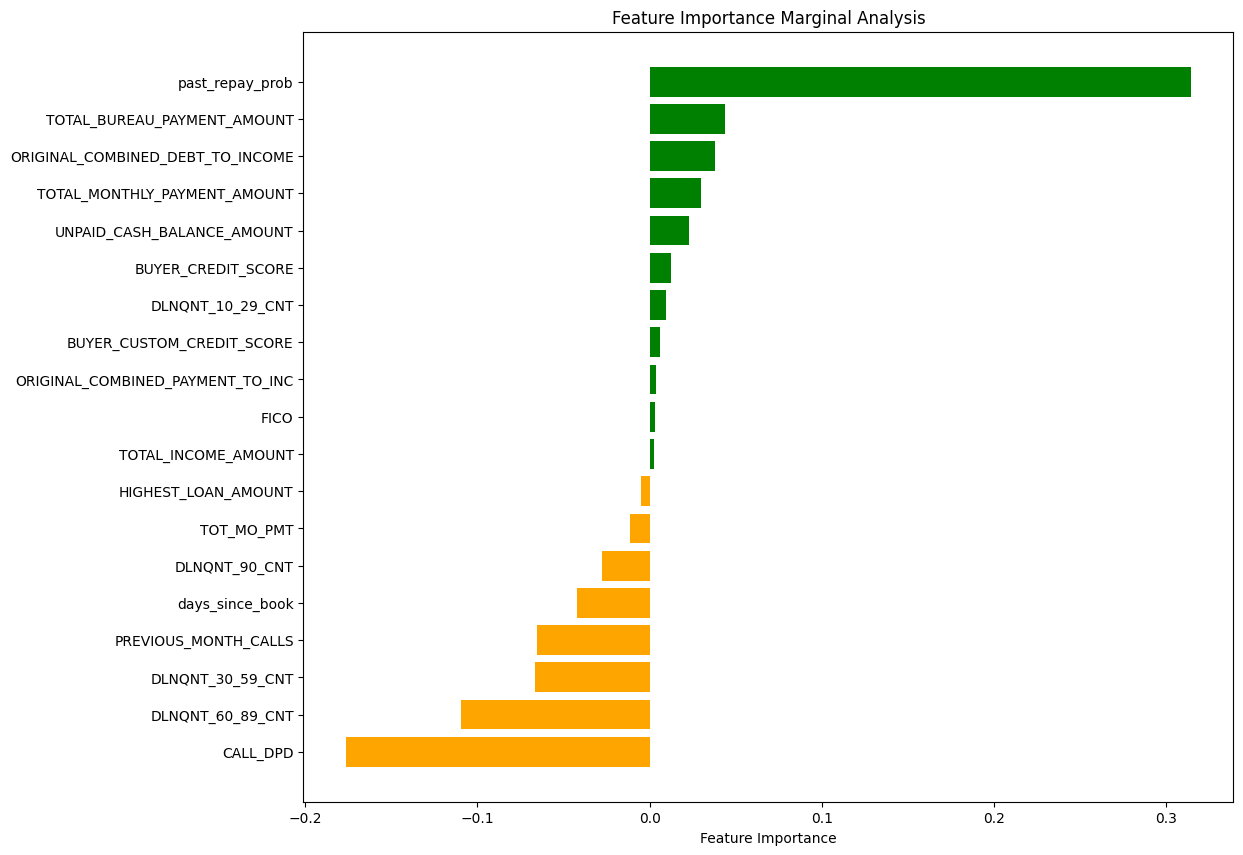

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df_train is your DataFrame
df_corr = df_train.drop(columns=['Customer_ID', 'CALL_MON_YEAR', 'outcome', 'CALL_START_DATE', 'APPLICANT_AGE', 'day_in_month'])

# Calculate the correlation of each feature with the target variable
correlations = df_corr.corrwith(df_train['outcome'])

# Sort correlations for better visualization
sorted_correlations = correlations.sort_values()

# Colors
colors = ['g' if value > 0 else 'orange' for value in sorted_correlations]

# Plotting
plt.figure(figsize=(12, 10))
plt.barh(sorted_correlations.index, sorted_correlations, color=colors)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Marginal Analysis')
plt.show()


In [55]:
max(df['CALL_START_DATE'])

Timestamp('2023-05-31 19:57:22')

In [56]:
min(df['CALL_START_DATE'])

Timestamp('2018-01-02 09:17:33')

In [57]:
import pandas as pd

# Assuming your dataset is named df

# Convert CALL_START_DATE to datetime if not already done
df['CALL_START_DATE'] = pd.to_datetime(df['CALL_START_DATE'])

# Group by Customer_ID
grouped = df.groupby('Customer_ID')

# Define a function to calculate the time span
def calculate_time_span(group):
    min_date = group['CALL_START_DATE'].min()
    max_date = group['CALL_START_DATE'].max()
    return max_date - min_date

# Apply the function to each group and get the maximum time span
max_time_span = grouped.apply(calculate_time_span).max()

print("Maximum time span:", max_time_span)


Maximum time span: 361 days 20:15:29


In [49]:
sorted_idx

['APPLICANT_AGE',
 'TOTAL_INCOME_AMOUNT',
 'FICO',
 'ORIGINAL_COMBINED_PAYMENT_TO_INC',
 'HIGHEST_LOAN_AMOUNT',
 'BUYER_CUSTOM_CREDIT_SCORE',
 'DLNQNT_10_29_CNT',
 'TOT_MO_PMT',
 'BUYER_CREDIT_SCORE',
 'UNPAID_CASH_BALANCE_AMOUNT',
 'DLNQNT_90_CNT',
 'TOTAL_MONTHLY_PAYMENT_AMOUNT',
 'ORIGINAL_COMBINED_DEBT_TO_INCOME',
 'days_since_book',
 'TOTAL_BUREAU_PAYMENT_AMOUNT',
 'PREVIOUS_MONTH_CALLS',
 'DLNQNT_30_59_CNT',
 'DLNQNT_60_89_CNT',
 'day_in_month',
 'CALL_DPD',
 'past_repay_prob']

In [11]:
tmp = pd.read_pickle('./data/result_df.pkl')
tmp[["Customer_ID", "CALL_MON_YEAR", "CALL_START_DATE", "outcome"]]

,Customer_ID,CALL_MON_YEAR,CALL_START_DATE,outcome
0,7350,2023-05,2023-05-11 15:03:46,0
1,8328,2023-01,2023-01-24 15:34:29,0
2,8328,2023-01,2023-01-27 14:49:59,0
3,8328,2023-01,2023-01-28 10:39:56,0
4,8328,2023-01,2023-01-28 10:41:35,0
...,...,...,...,...
118699,99992127,2023-03,2023-03-01 11:58:11,1
118700,99992127,2023-04,2023-04-26 12:00:47,1
118701,99995487,2022-05,2022-05-16 12:03:06,0
118702,99995487,2022-05,2022-05-16 12:03:53,0
